In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

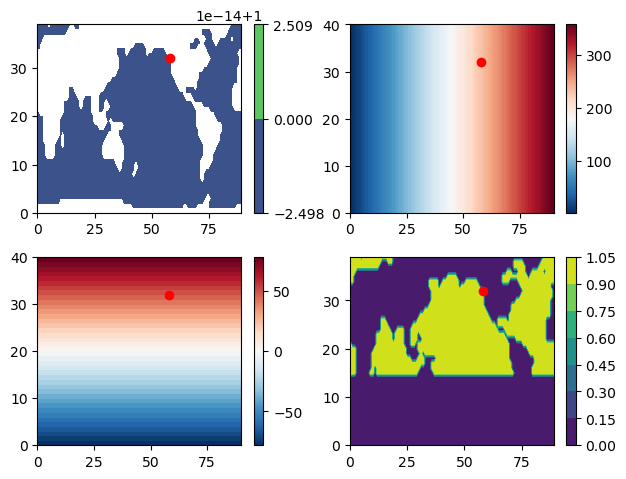

In [2]:
mainDir = '/scratch2/pillarh/MITgcm_nonECCO/RUNS_FROM_STAMPEDE2/global_oce_latlon_4x4'
spinupDir = mainDir + '/run_spinup'
gridDir = spinupDir + '/GRID'

nx = 90
ny = 40
nz = 15

latc = np.reshape(np.fromfile(gridDir + '/YC.data', 
                              dtype = '>f'), (ny, nx))
lonc = np.reshape(np.fromfile(gridDir + '/XC.data', 
                              dtype = '>f'), (ny, nx))
hfacc = np.reshape(np.fromfile(gridDir + '/hFacC.data', 
                              dtype = '>f'), (nz, ny, nx))

pmask = hfacc>0
pmask = pmask.astype(np.float32)
pmask[pmask == 0.0] = np.nan

fig, ax = plt.subplots(2,2)
fig.tight_layout()

pc = ax[0,0].contourf(pmask[0], cmap = 'viridis')
ax[0,0].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[0,0])

pc = ax[1,0].pcolor(latc, cmap = 'RdBu_r')
ax[1,0].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[1,0])

pc = ax[0,1].pcolor(lonc, cmap = 'RdBu_r')
ax[0,1].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[0,1])

latmask = latc >= -20
mask = pmask[0]
mask[np.isnan(mask)] = 0.0
latmask = mask * latmask
pc = ax[1,1].contourf(latmask, cmap = 'viridis')
ax[1,1].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[1,1])

In [3]:
### Number of wetpoints
int(np.sum(latmask))

1217

In [4]:
exptname = ['run_forward_50yr_dailydump_pk000059400', 
            'run_forward_50yr_dailydump_pk000061200']
diagsets = 'state3d_TS'
costLon  = 240
costLat  = 50

nx = 90
ny = 40
nz = 15

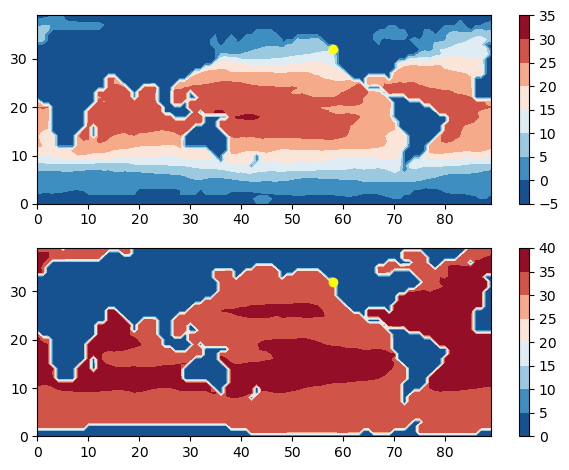

In [5]:
ThetaDirs = [mainDir + '/run_forward_50yr_dailydump_pk000059400/diags/untarred_output',
             mainDir + '/run_forward_50yr_dailydump_pk000061200/diags/untarred_output']

file0 = ThetaDirs[0] + '/' + 'state3d_TS.0000594001.data'

T0 = np.reshape(np.fromfile(file0, dtype = '>f')[:nx*ny*nz], (nz, ny, nx))
S0 = np.reshape(np.fromfile(file0, dtype = '>f')[nx*ny*nz:], (nz, ny, nx))

fig, ax = plt.subplots(2,1)
fig.tight_layout()

pc = ax[0].contourf(T0[0]*pmask[0], cmap = 'RdBu_r')
ax[0].scatter([58],[32], color = 'yellow')
fig.colorbar(pc, ax=ax[0])

pc = ax[1].contourf(S0[0]*pmask[0], cmap = 'RdBu_r')
ax[1].scatter([58],[32], color = 'yellow')
fig.colorbar(pc, ax=ax[1])

In [6]:
files_list = []
for i in range(18000):
    index = 594001 + i
    files_list.append(ThetaDirs[0] + '/' + f'state3d_TS.0000{index:6d}.data')
for i in range(18000):
    index = 612001 + i
    files_list.append(ThetaDirs[1] + '/' + f'state3d_TS.0000{index:6d}.data')

In [7]:
thetaSurf = np.zeros((len(files_list), ny, nx))
cost = np.zeros((len(files_list), 1))
for i in range(len(files_list)):
    thetaSurf[i] = np.reshape(np.fromfile(files_list[i], dtype = '>f')[:nx*ny*nz],
                          (nz, ny, nx))[0]
    cost[i] = thetaSurf[i,32,58]

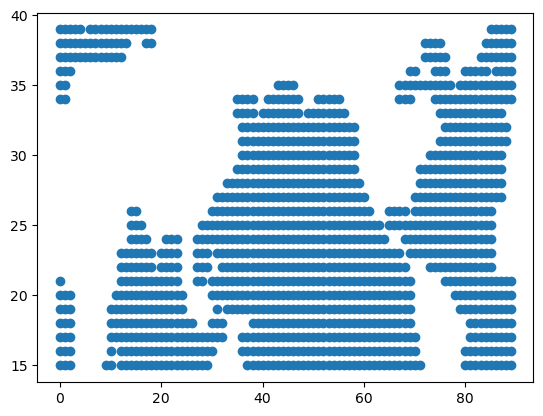

In [8]:
wetpoints = np.nonzero(latmask)
thetaSurfWet = thetaSurf[:, wetpoints[0], wetpoints[1]]
plt.scatter(wetpoints[1], wetpoints[0])

In [9]:
Layers = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 10                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(thetaSurfWet, cost, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    100, 50, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()
cost_predict = best_model.predict(thetaSurfWet)

L = TrainLR(thetaSurfWet, cost, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

cost_predict_LR = regr.predict(thetaSurfWet)

Train on 28800 samples, validate on 7200 samples
Epoch 1/50
  100/28800 [..............................] - ETA: 29s - loss: 224.7175 - mae: 14.8782

2023-08-01 05:18:03.055385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-2.1.3/installation/lib:/share/jdk-16.0.1/lib::
2023-08-01 05:18:03.055430: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-01 05:18:03.055456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c5-3): /proc/driver/nvidia/version does not exist
2023-08-01 05:18:03.055946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural N

28000/28800 [============================>.] - ETA: 0s - loss: 3.7887 - mae: 0.8696
Epoch 1: val_loss improved from inf to 0.02433, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 51us/sample - loss: 3.6842 - mae: 0.8490 - val_loss: 0.0243 - val_mae: 0.1141
Epoch 2/50
27500/28800 [===========================>..] - ETA: 0s - loss: 0.0173 - mae: 0.1063
Epoch 2: val_loss improved from 0.02433 to 0.01261, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 37us/sample - loss: 0.0172 - mae: 0.1060 - val_loss: 0.0126 - val_mae: 0.0942
Epoch 3/50
28200/28800 [============================>.] - ETA: 0s - loss: 0.0119 - mae: 0.0896
Epoch 3: val_loss did not improve from 0.01261
28800/28800 [==============================] - 1s 37us/sample - loss: 0.0118 - mae: 0.0894 - val_loss: 0.0129 - val_mae: 0.0920
Epoch 4/50
27900/28800 [============================>.] - ETA: 0s - loss: 0.0097 - mae:

28000/28800 [============================>.] - ETA: 0s - loss: 0.0208 - mae: 0.0924
Epoch 29: val_loss did not improve from 0.00072
28800/28800 [==============================] - 1s 43us/sample - loss: 0.0203 - mae: 0.0913 - val_loss: 0.0069 - val_mae: 0.0784
Epoch 30/50
28300/28800 [============================>.] - ETA: 0s - loss: 0.0263 - mae: 0.1128
Epoch 30: val_loss did not improve from 0.00072
28800/28800 [==============================] - 1s 43us/sample - loss: 0.0286 - mae: 0.1171 - val_loss: 0.4705 - val_mae: 0.6779
Epoch 31/50
27500/28800 [===========================>..] - ETA: 0s - loss: 0.0223 - mae: 0.1063
Epoch 31: val_loss did not improve from 0.00072
28800/28800 [==============================] - 1s 40us/sample - loss: 0.0227 - mae: 0.1090 - val_loss: 0.0072 - val_mae: 0.0803
Epoch 32/50
27900/28800 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.1209
Epoch 32: val_loss did not improve from 0.00072
28800/28800 [==============================] - 1s 44

In [10]:
base_pt = 0
num_rel = 3
normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.00}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', thetaSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_a1b0 = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_a1b0[:,:,:] = np.nan
rel_a1b0[:,wetpoints[0],wetpoints[1]] = a

X = XAIR(best_model, 'lrp.z', 'classic', thetaSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_z = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_z[:,:,:] = np.nan
rel_z[:,wetpoints[0],wetpoints[1]] = a

XL = XLR(regr, thetaSurfWet)
a_LR, stats_LR = XL.quick_analyze()

rel_LR = np.zeros(thetaSurf.shape)
rel_LR[:,:,:] = np.nan
rel_LR[:,wetpoints[0],wetpoints[1]] = a_LR

Text(0.5, 1.0, 'LRP_LR')

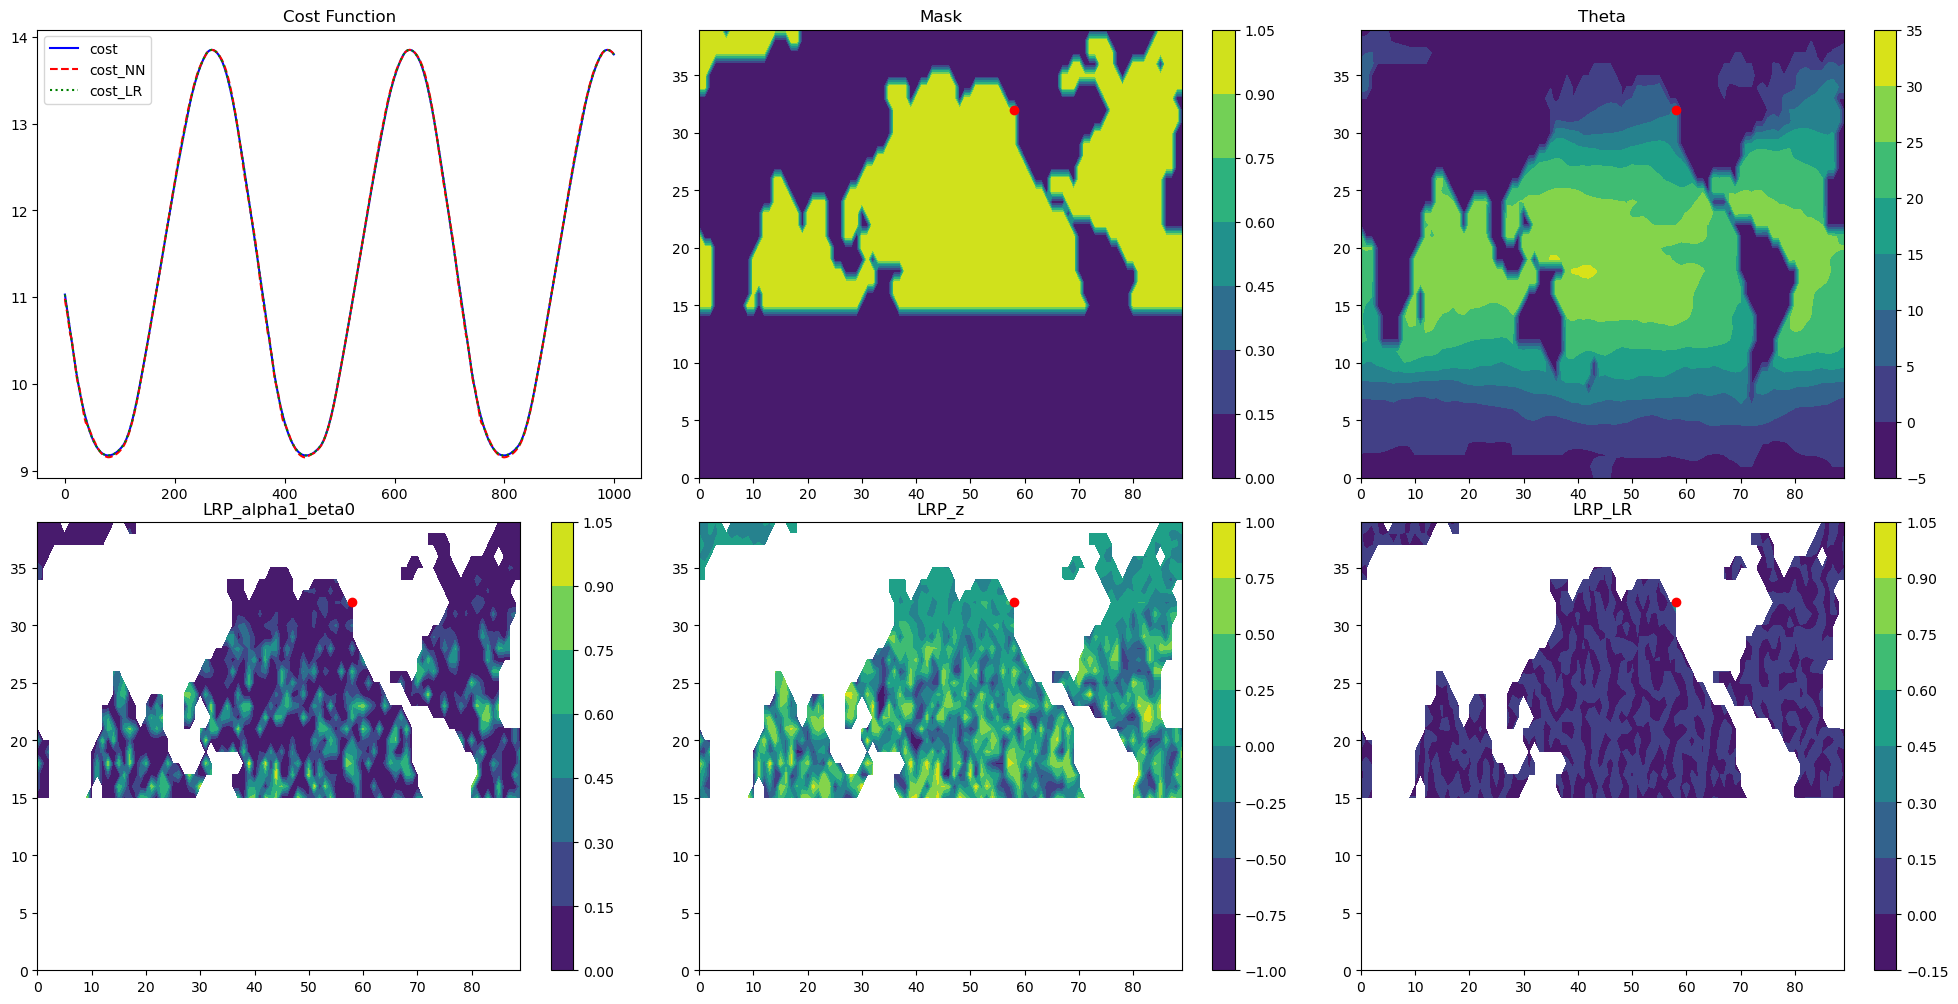

In [11]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
fig.tight_layout()

ax[0,0].plot(cost[:1000], 'b', label = 'cost')
ax[0,0].plot(cost_predict[:1000], 'r--', label = 'cost_NN')
ax[0,0].plot(cost_predict_LR[:1000], 'g:', label = 'cost_LR')
ax[0,0].legend()
ax[0,0].set_title('Cost Function')

p = ax[0,1].contourf(latmask)
ax[0,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,1])
ax[0,1].set_title('Mask')

p = ax[0,2].contourf(thetaSurf[2])
ax[0,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,2])
ax[0,2].set_title('Theta')

p = ax[1,0].contourf(rel_a1b0[2])
ax[1,0].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,0])
ax[1,0].set_title('LRP_alpha1_beta0')

p = ax[1,1].contourf(rel_z[2])
ax[1,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,1])
ax[1,1].set_title('LRP_z')

p = ax[1,2].contourf(rel_LR[2])
ax[1,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,2])
ax[1,2].set_title('LRP_LR')

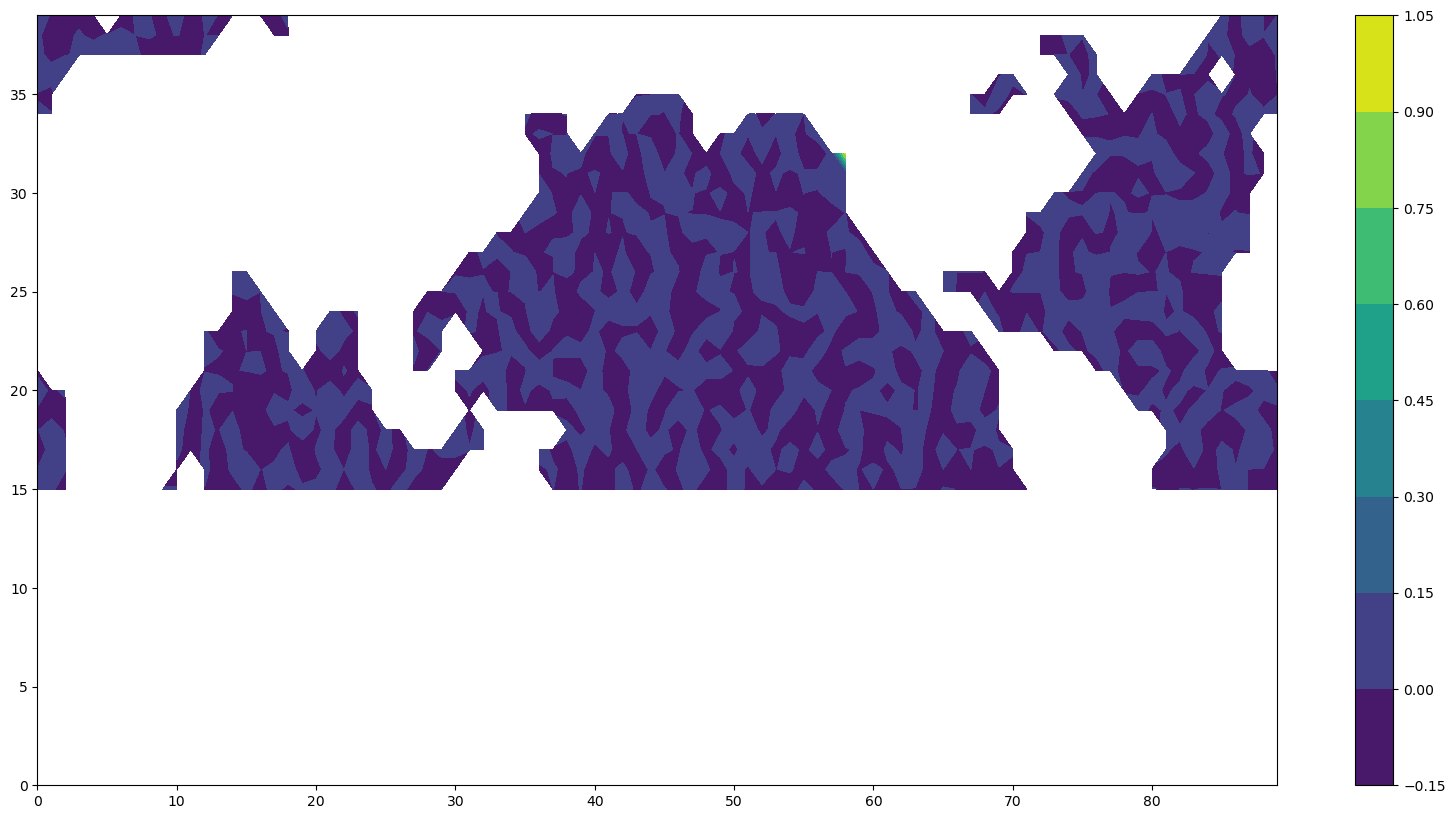

In [12]:
plt.contourf(np.mean(rel_LR, axis = 0))
plt.colorbar()

In [13]:
thetaSurf = np.zeros((len(files_list), ny, nx))
cost = np.zeros((len(files_list), 1))
for i in range(len(files_list)):
    thetaSurf[i] = np.reshape(np.fromfile(files_list[i], dtype = '>f')[:nx*ny*nz],
                          (nz, ny, nx))[0]
    cost[i] = thetaSurf[i,32,58]
    
wetpoints = np.nonzero(latmask)

temp = thetaSurf[:,20:25,40:50]
thetaSurfOrig = np.copy(thetaSurf)
thetaSurf = thetaSurf*0.0
thetaSurf[:,20:25,40:50] = temp

latmask = latc >= -20
mask = pmask[0]
mask[np.isnan(mask)] = 0.0
latmask = mask * latmask
temp = latmask[20:25,40:50]
latmask[20:25,40:50] = temp + 1

thetaSurfWet = thetaSurf[:, wetpoints[0], wetpoints[1]]

In [14]:
Layers = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 10                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(thetaSurfWet, cost, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    100, 200, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()
cost_predict = best_model.predict(thetaSurfWet)

L = TrainLR(thetaSurfWet, cost, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

cost_predict_LR = regr.predict(thetaSurfWet)

Train on 28800 samples, validate on 7200 samples
Epoch 1/200
27500/28800 [===========================>..] - ETA: 0s - loss: 2.5633 - mae: 1.3961
Epoch 1: val_loss improved from inf to 2.20846, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 51us/sample - loss: 2.5431 - mae: 1.3917 - val_loss: 2.2085 - val_mae: 1.3292
Epoch 2/200
27800/28800 [===========================>..] - ETA: 0s - loss: 2.0718 - mae: 1.2954
Epoch 2: val_loss improved from 2.20846 to 1.96518, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 46us/sample - loss: 2.0667 - mae: 1.2936 - val_loss: 1.9652 - val_mae: 1.2621
Epoch 3/200
27600/28800 [===========================>..] - ETA: 0s - loss: 1.8588 - mae: 1.2282
Epoch 3: val_loss improved from 1.96518 to 1.70324, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 47us/sample - loss: 1.8529 - mae: 1.2263 - 

Epoch 27/200
28000/28800 [============================>.] - ETA: 0s - loss: 0.1019 - mae: 0.2536
Epoch 27: val_loss did not improve from 0.09736
28800/28800 [==============================] - 1s 37us/sample - loss: 0.1019 - mae: 0.2538 - val_loss: 0.1155 - val_mae: 0.2382
Epoch 28/200
28800/28800 [==============================] - ETA: 0s - loss: 0.1060 - mae: 0.2581
Epoch 28: val_loss did not improve from 0.09736
28800/28800 [==============================] - 1s 37us/sample - loss: 0.1060 - mae: 0.2581 - val_loss: 0.1153 - val_mae: 0.3083
Epoch 29/200
28700/28800 [============================>.] - ETA: 0s - loss: 0.1011 - mae: 0.2532
Epoch 29: val_loss improved from 0.09736 to 0.08269, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 45us/sample - loss: 0.1011 - mae: 0.2532 - val_loss: 0.0827 - val_mae: 0.2220
Epoch 30/200
28500/28800 [============================>.] - ETA: 0s - loss: 0.0953 - mae: 0.2452
Epoch 30: val_loss did no

27800/28800 [===========================>..] - ETA: 0s - loss: 0.0640 - mae: 0.2026
Epoch 54: val_loss improved from 0.04890 to 0.04673, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 38us/sample - loss: 0.0635 - mae: 0.2015 - val_loss: 0.0467 - val_mae: 0.1688
Epoch 55/200
27900/28800 [============================>.] - ETA: 0s - loss: 0.0568 - mae: 0.1909
Epoch 55: val_loss did not improve from 0.04673
28800/28800 [==============================] - 1s 43us/sample - loss: 0.0566 - mae: 0.1906 - val_loss: 0.0474 - val_mae: 0.1700
Epoch 56/200
28600/28800 [============================>.] - ETA: 0s - loss: 0.0617 - mae: 0.1991
Epoch 56: val_loss did not improve from 0.04673
28800/28800 [==============================] - 1s 42us/sample - loss: 0.0616 - mae: 0.1989 - val_loss: 0.0560 - val_mae: 0.1972
Epoch 57/200
28400/28800 [============================>.] - ETA: 0s - loss: 0.0540 - mae: 0.1859
Epoch 57: val_loss did not improve fro

Epoch 83/200
27500/28800 [===========================>..] - ETA: 0s - loss: 0.0379 - mae: 0.1564
Epoch 83: val_loss did not improve from 0.03170
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0382 - mae: 0.1571 - val_loss: 0.0593 - val_mae: 0.2062
Epoch 84/200
27700/28800 [===========================>..] - ETA: 0s - loss: 0.0392 - mae: 0.1599
Epoch 84: val_loss improved from 0.03170 to 0.02859, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 32us/sample - loss: 0.0389 - mae: 0.1592 - val_loss: 0.0286 - val_mae: 0.1364
Epoch 85/200
27700/28800 [===========================>..] - ETA: 0s - loss: 0.0366 - mae: 0.1538
Epoch 85: val_loss did not improve from 0.02859
28800/28800 [==============================] - 1s 36us/sample - loss: 0.0365 - mae: 0.1537 - val_loss: 0.0355 - val_mae: 0.1574
Epoch 86/200
28800/28800 [==============================] - ETA: 0s - loss: 0.0372 - mae: 0.1552
Epoch 86: val_loss did no

Epoch 111/200
28700/28800 [============================>.] - ETA: 0s - loss: 0.0269 - mae: 0.1328
Epoch 111: val_loss improved from 0.01972 to 0.01876, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 32us/sample - loss: 0.0269 - mae: 0.1330 - val_loss: 0.0188 - val_mae: 0.1097
Epoch 112/200
28400/28800 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.1342
Epoch 112: val_loss did not improve from 0.01876
28800/28800 [==============================] - 1s 39us/sample - loss: 0.0276 - mae: 0.1345 - val_loss: 0.0189 - val_mae: 0.1098
Epoch 113/200
27900/28800 [============================>.] - ETA: 0s - loss: 0.0307 - mae: 0.1412
Epoch 113: val_loss did not improve from 0.01876
28800/28800 [==============================] - 1s 36us/sample - loss: 0.0306 - mae: 0.1409 - val_loss: 0.0244 - val_mae: 0.1235
Epoch 114/200
27500/28800 [===========================>..] - ETA: 0s - loss: 0.0280 - mae: 0.1361
Epoch 114: val_los

27700/28800 [===========================>..] - ETA: 0s - loss: 0.0222 - mae: 0.1204
Epoch 139: val_loss did not improve from 0.01454
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0220 - mae: 0.1197 - val_loss: 0.0179 - val_mae: 0.1127
Epoch 140/200
27500/28800 [===========================>..] - ETA: 0s - loss: 0.0215 - mae: 0.1185
Epoch 140: val_loss did not improve from 0.01454
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0212 - mae: 0.1177 - val_loss: 0.0209 - val_mae: 0.1239
Epoch 141/200
27800/28800 [===========================>..] - ETA: 0s - loss: 0.0228 - mae: 0.1219
Epoch 141: val_loss improved from 0.01454 to 0.01433, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0225 - mae: 0.1210 - val_loss: 0.0143 - val_mae: 0.0951
Epoch 142/200
28700/28800 [============================>.] - ETA: 0s - loss: 0.0232 - mae: 0.1225
Epoch 142: val_loss improved fro

28000/28800 [============================>.] - ETA: 0s - loss: 0.0194 - mae: 0.1126
Epoch 167: val_loss did not improve from 0.01107
28800/28800 [==============================] - 1s 30us/sample - loss: 0.0196 - mae: 0.1131 - val_loss: 0.0195 - val_mae: 0.1126
Epoch 168/200
28300/28800 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.1171
Epoch 168: val_loss did not improve from 0.01107
28800/28800 [==============================] - 1s 30us/sample - loss: 0.0209 - mae: 0.1169 - val_loss: 0.0123 - val_mae: 0.0877
Epoch 169/200
27600/28800 [===========================>..] - ETA: 0s - loss: 0.0150 - mae: 0.0983
Epoch 169: val_loss did not improve from 0.01107
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0151 - mae: 0.0985 - val_loss: 0.0446 - val_mae: 0.1886
Epoch 170/200
27700/28800 [===========================>..] - ETA: 0s - loss: 0.0209 - mae: 0.1167
Epoch 170: val_loss improved from 0.01107 to 0.01078, saving model to /home/shreyas/XAIRT/e

27800/28800 [===========================>..] - ETA: 0s - loss: 0.0146 - mae: 0.0976
Epoch 196: val_loss did not improve from 0.00947
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0145 - mae: 0.0971 - val_loss: 0.0097 - val_mae: 0.0806
Epoch 197/200
27100/28800 [===========================>..] - ETA: 0s - loss: 0.0168 - mae: 0.1047
Epoch 197: val_loss did not improve from 0.00947
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0169 - mae: 0.1049 - val_loss: 0.0270 - val_mae: 0.1447
Epoch 198/200
27700/28800 [===========================>..] - ETA: 0s - loss: 0.0178 - mae: 0.1065
Epoch 198: val_loss improved from 0.00947 to 0.00898, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 31us/sample - loss: 0.0178 - mae: 0.1065 - val_loss: 0.0090 - val_mae: 0.0741
Epoch 199/200
27600/28800 [===========================>..] - ETA: 0s - loss: 0.0198 - mae: 0.1134
Epoch 199: val_loss did not impr

In [15]:
base_pt = 0
num_rel = 3
normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.00}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', thetaSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_a1b0 = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_a1b0[:,:,:] = np.nan
rel_a1b0[:,wetpoints[0],wetpoints[1]] = a

X = XAIR(best_model, 'lrp.z', 'classic', thetaSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_z = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_z[:,:,:] = np.nan
rel_z[:,wetpoints[0],wetpoints[1]] = a

XL = XLR(regr, thetaSurfWet)
a_LR, stats_LR = XL.quick_analyze()

rel_LR = np.zeros(thetaSurf.shape)
rel_LR[:,:,:] = np.nan
rel_LR[:,wetpoints[0],wetpoints[1]] = a_LR

Text(0.5, 1.0, 'LRP_LR')

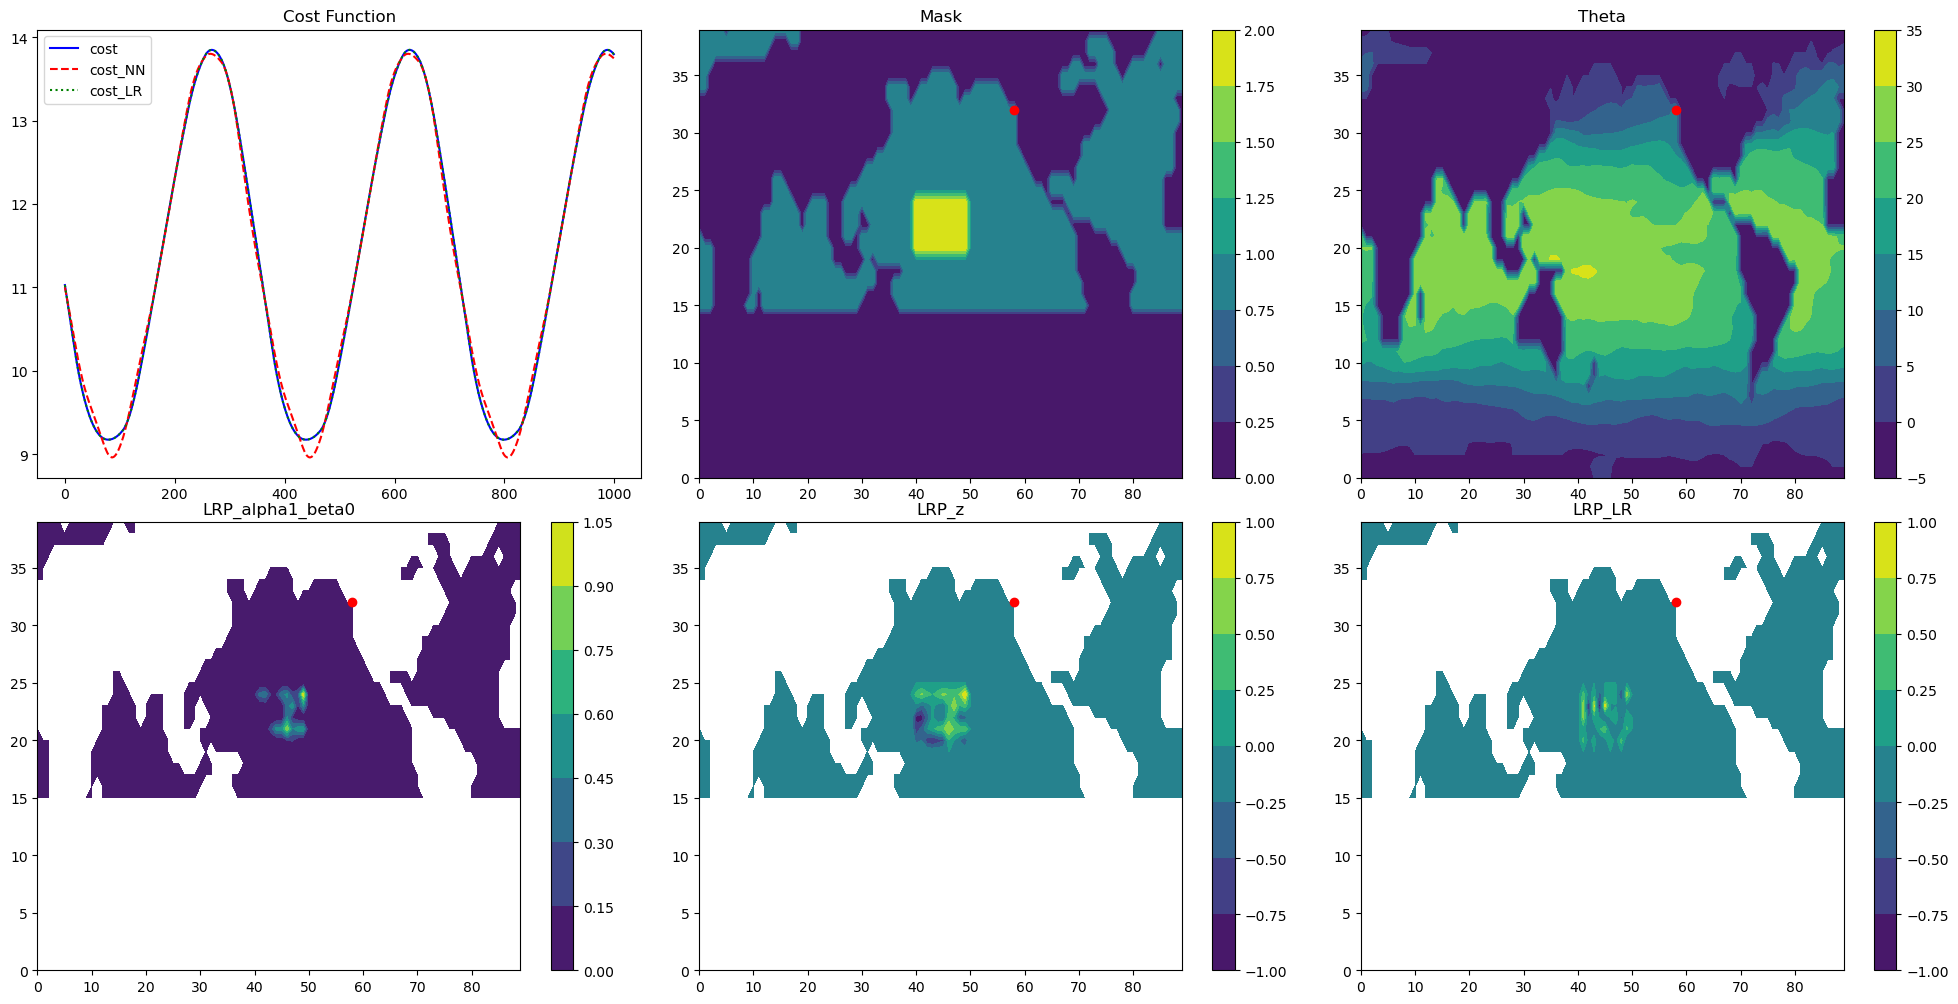

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
fig.tight_layout()

ax[0,0].plot(cost[:1000], 'b', label = 'cost')
ax[0,0].plot(cost_predict[:1000], 'r--', label = 'cost_NN')
ax[0,0].plot(cost_predict_LR[:1000], 'g:', label = 'cost_LR')
ax[0,0].legend()
ax[0,0].set_title('Cost Function')

p = ax[0,1].contourf(latmask)
ax[0,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,1])
ax[0,1].set_title('Mask')

p = ax[0,2].contourf(thetaSurfOrig[2])
ax[0,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,2])
ax[0,2].set_title('Theta')

p = ax[1,0].contourf(rel_a1b0[2])
ax[1,0].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,0])
ax[1,0].set_title('LRP_alpha1_beta0')

p = ax[1,1].contourf(rel_z[2])
ax[1,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,1])
ax[1,1].set_title('LRP_z')

p = ax[1,2].contourf(rel_LR[2])
ax[1,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,2])
ax[1,2].set_title('LRP_LR')

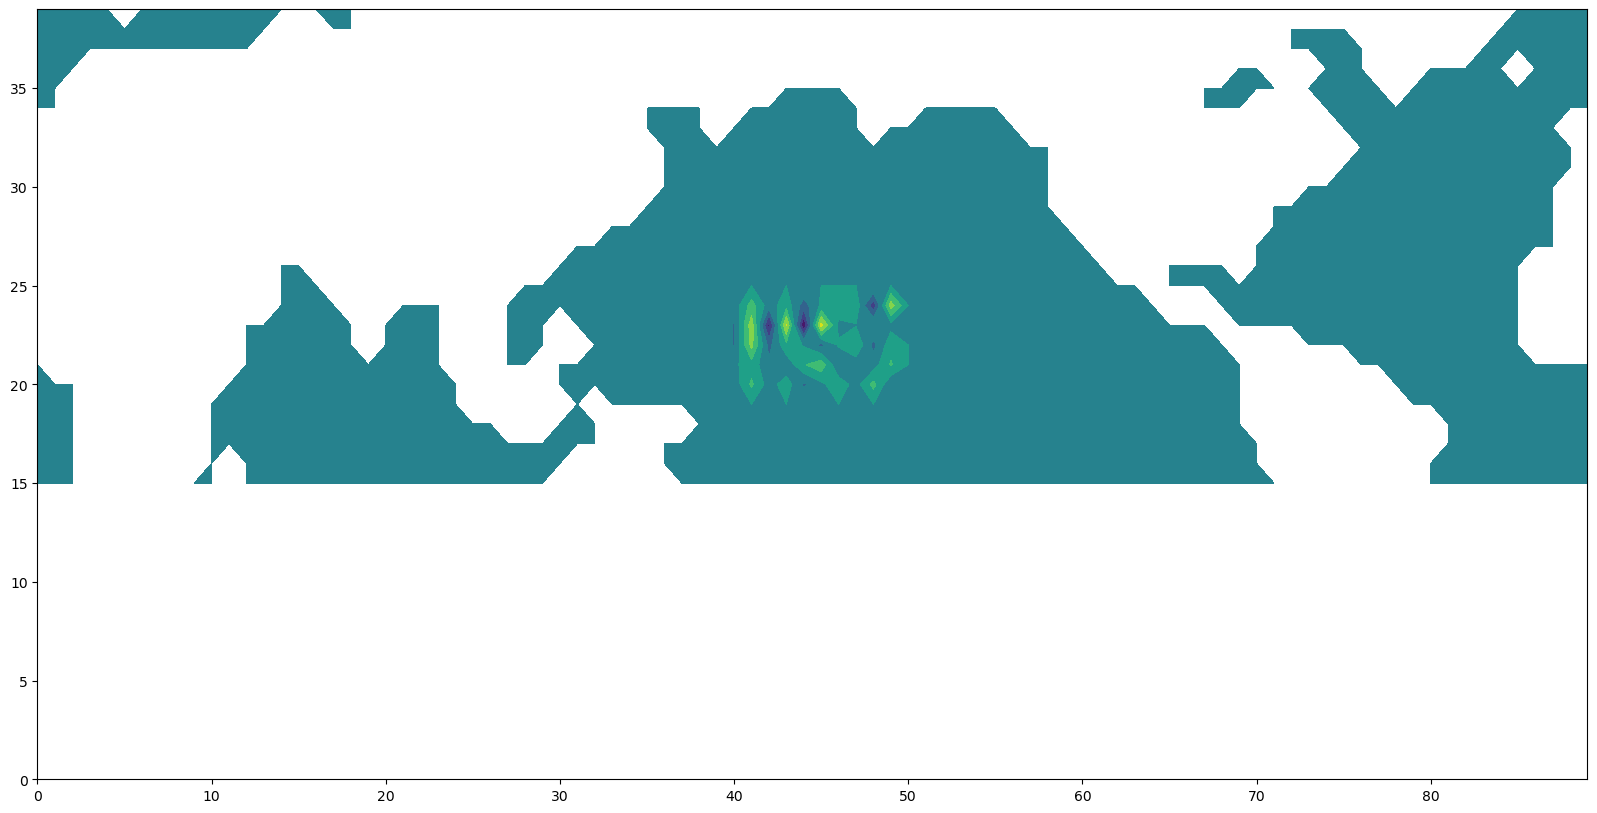

In [17]:
plt.contourf(np.mean(rel_LR, axis = 0))